# Бібліотеки, модулі



In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.2 MB/s eta 0:00:00


In [6]:
import pickle
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, ExtraTreesClassifier, BaggingRegressor, BaggingClassifier, StackingRegressor, StackingClassifier
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from mlxtend.frequent_patterns import apriori, association_rules

# Функції

In [7]:
def df_stats(df):
    print("Загальна інформація про дані:")
    print(df.info())
    print("\nКількість унікальних значень за всіма ознаками:")
    print(df.nunique())
    print("\nРозрахунок основних статистичних показників за числовими ознаками:")
    print(df.describe())


def plot_nan_percentage(df):
    percentage = np.around(df.isna().mean() * 100, decimals=2)
    importance = [{p < 15: "olivedrab", p >= 15: "indianred"}[True] for p in percentage]
    plt.figure(figsize=(10, 6))
    plt.bar(df.columns, height=list(percentage), color=importance)
    plt.axhline(y=15, color='black', linestyle='--', label='поріг у 15%')
    plt.xticks(rotation=90)
    plt.legend()
    plt.title("Відсоток пропущених даних")
    plt.show()


def fill_nan(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode().iloc[0])
        elif df[col].dtype == 'float64':
            df[col] = df[col].fillna(df[col].median())
    if not df.isna().any().any():
        print("NaN для числових ознак успішно заповнені медіаною, для категоріальних - модою")


def anomaly_check(df, mode='init'):
    float_cols = df.loc[:, "Age":"Frequency (Video game music)"].select_dtypes(include=['float64'])
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i, column in enumerate(float_cols.columns):
        axs[i].boxplot(float_cols[column])
        axs[i].set_title(column)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    if mode == 'init':
        plt.suptitle("Коробкві графіки для числових ознак до видалення аномалій")
    elif mode == 'check':
        plt.suptitle("Коробкві графіки для числових ознак після видалення аномалій")
    plt.show()


def get_X_y(df):
    drop = df.columns[df.columns.get_loc('Anxiety'):df.columns.get_loc('OCD')+1]
    X = df.drop(columns=drop)
    y = df.loc[:, "Anxiety":"OCD"]
    return X, y


def encode(arr, mode='obj'):
    arr_enc = arr.copy()
    le = LabelEncoder()
    if mode == 'obj':
        for col in arr.select_dtypes(include=['object']):
            arr_enc[col] = le.fit_transform(arr[col])
    elif mode == 'all':
        for col in arr:
            arr_enc[col] = le.fit_transform(arr[col])
    return arr_enc


def scale(X, mode):
    X_scaled = X.copy()
    if mode == 'minmax':
        scaler = MinMaxScaler()
    elif mode == 'standard':
        scaler = StandardScaler()
    for col in X_scaled.select_dtypes(include=['float64']):
        X_scaled[col] = scaler.fit_transform(X_scaled[[col]])
    return X_scaled


def plot_distribution(X, mode='init'):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i, col in enumerate(X.select_dtypes(include=['float64']).columns):
        X[col].hist(bins=20, ax=axs[i])
        axs[i].set_title(col)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    if mode == 'init':
        plt.suptitle("Розподіл числових ознак до масштабування")
    elif mode == 'minmax':
        plt.suptitle("Розподіл числових ознак після нормалізації")
    elif mode == 'standard':
        plt.suptitle("Розподіл числових ознак після стандартизації")
    plt.show()


def plot_variables(y):
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
    axs[0, 0].bar(y["Anxiety"].value_counts().index, y["Anxiety"].value_counts().values, color=matplotlib.colormaps.get_cmap('tab20')(np.linspace(0, 1, len(y["Anxiety"].value_counts()))))
    axs[0, 1].bar(y["Insomnia"].value_counts().index, y["Insomnia"].value_counts().values, color=matplotlib.colormaps.get_cmap('tab20')(np.linspace(0, 1, len(y["Insomnia"].value_counts()))))
    axs[1, 0].bar(y["Depression"].value_counts().index, y["Depression"].value_counts().values, color=matplotlib.colormaps.get_cmap('tab20')(np.linspace(0, 1, len(y["Depression"].value_counts()))))
    axs[1, 1].bar(y["OCD"].value_counts().index, y["OCD"].value_counts().values, color=matplotlib.colormaps.get_cmap('tab20')(np.linspace(0, 1, len(y["OCD"].value_counts()))))
    axs[0, 0].set_title("Anxiety")
    axs[0, 1].set_title("Insomnia")
    axs[1, 0].set_title("Depression")
    axs[1, 1].set_title("OCD")
    fig.suptitle("Розподіл значень цільових змінних")
    plt.show()


def correlation(arr, mode='features'):
    plt.figure(figsize=(20, 8))
    sns.heatmap(arr.corr(), annot=True, vmin=-1, vmax=1, center=0)
    sns.heatmap(arr.corr(), annot=True, vmin=-1, vmax=1, center=0)
    if mode == 'features':
        plt.title("Матриця кореляції ознак")
    elif mode == 'variables':
        plt.title("Матриця кореляції цільових змінних")
    plt.tight_layout()
    plt.show()


def grid_search(X, y, param_grid, method):
    if method == 'svr':
        model = SVR()
    elif method == 'rf':
        model = RandomForestRegressor(random_state=42)
    elif method == 'et':
        model = ExtraTreesRegressor(random_state=42)
    elif method == 'bg':
        with open(f'/content/drive/MyDrive/Diploma/Regression/best_model_et.pkl', 'rb') as f:
            base_estimator = pickle.load(f)
        model = BaggingRegressor(estimator=base_estimator, random_state=42)
    elif method == 'xgb':
        model = XGBRegressor(random_state=42)
    elif method == 'lgbm':
        model = LGBMRegressor(random_state=42)
    elif method == 'cat':
        model = CatBoostRegressor(random_seed=42, verbose=False)
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    str_params = {k: str(v) if isinstance(v, float) else v for k, v in best_params.items()}
    df = pd.DataFrame.from_dict(str_params, orient='index', columns=['Найкраще значення'])
    df.columns.name = 'Параметр'
    df = df.to_string(justify='center')
    print(df)
    best_model = grid_search.best_estimator_
    with open(f'/content/drive/MyDrive/Diploma/Regression/best_model_{method}.pkl', 'wb') as f:
        pickle.dump(best_model, f)


def select_features(X1, X2, y, mode, per=1):
    with open('/content/drive/MyDrive/Diploma/Regression/best_model_rf.pkl', 'rb') as f:
        model = pickle.load(f)
    model.fit(X1, y)
    percentage = np.around(model.feature_importances_*100, decimals=2)
    plt.figure(figsize=(10, 6))
    if mode == 'thresh':
        mask = percentage >= per
        importance = [{p < per: "indianred", p >= per: "olivedrab"}[True] for p in percentage]
        df1 = X1.loc[:, mask]
        df2 = X2.loc[:, mask]
        plt.bar(X1.columns, height=list(percentage), color=importance)
        plt.axhline(y=per, color='black', linestyle='--', label=f'поріг у {per}%')
        plt.title("Відсоток значущості ознак")
        plt.legend()
    if mode == 'rec':
        rfecv = RFECV(estimator=model, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
        rfecv.fit(X1, y)
        df1 = X1[X1.columns[rfecv.support_]]
        df2 = X2[X2.columns[rfecv.support_]]
        mask = ['indianred' if not selected else 'olivedrab' for selected in rfecv.support_]
        plt.bar(X1.columns, height=list(percentage), color=mask)
        plt.title("Відсоток значущості рекурсивно обраних ознак")
    plt.xticks(rotation=90)
    plt.show()
    return df1, df2


def make_splits(X, y, number=2):
    if number == 2:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        return X_train, X_test, y_train, y_test
    elif number == 3:
        X_train, X_check, y_train, y_check = train_test_split(X, y, test_size=0.3, random_state=42)
        X_test, X_val, y_test, y_val = train_test_split(X_check, y_check, test_size=0.5, random_state=42)
        return X_train, X_test, X_val, y_train, y_test, y_val


def y_division(y):
    y1 = y["Anxiety"]
    y2 = y["Insomnia"]
    y3 = y["Depression"]
    y4 = y["OCD"]
    return [y1, y2, y3, y4]


def calculate_metrics(y_train, y_train_pred, y_test, y_test_pred):
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    return [train_rmse, test_rmse, train_mae, test_mae, train_r2, test_r2]


def calculate_clf_metrics(y_train, y_train_pred, y_test, y_test_pred):
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    return [train_accuracy, test_accuracy]


def average_metrics(m1, m2, m3, m4):
    train_rmse = np.mean(np.array([m1[0], m2[0], m3[0], m4[0]]))
    test_rmse = np.mean(np.array([m1[1], m2[1], m3[1], m4[1]]))
    train_mae = np.mean(np.array([m1[2], m2[2], m3[2], m4[2]]))
    test_mae = np.mean(np.array([m1[3], m2[3], m3[3], m4[3]]))
    train_r2 = np.mean(np.array([m1[4], m2[4], m3[4], m4[4]]))
    test_r2 = np.mean(np.array([m1[5], m2[5], m3[5], m4[5]]))
    total_time = np.mean(np.array([m1[6], m2[6], m3[6], m4[6]]))
    return [train_rmse, test_rmse, train_mae, test_mae, train_r2, test_r2, total_time]


def average_clf_metrics(m1, m2, m3, m4):
    train_accuracy = np.mean(np.array([m1[0], m2[0], m3[0], m4[0]]))
    test_accuracy = np.mean(np.array([m1[1], m2[1], m3[1], m4[1]]))
    total_time = np.mean(np.array([m1[2], m2[2], m3[2], m4[2]]))
    return [train_accuracy, test_accuracy, total_time]


def prediction(X_train, X_test, y_train, y_test, model, clf, rounded, flag=False):
    if clf:
        with open(f'/content/drive/MyDrive/Diploma/Classification/best_model_{model}.pkl', 'rb') as f:
            model = pickle.load(f)
    else:
        with open(f'/content/drive/MyDrive/Diploma/Regression/best_model_{model}.pkl', 'rb') as f:
            model = pickle.load(f)
    if clf == True and model == 'st' and flag == True:
        pass
    else:
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        total_time = end_time - start_time
    if rounded:
        y_train_pred = np.round(model.predict(X_train)*2)/2
        y_test_pred = np.round(model.predict(X_test)*2)/2
    else:
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    if clf:
        metrics = calculate_clf_metrics(y_train, y_train_pred, y_test, y_test_pred)
    else:
        metrics = calculate_metrics(y_train, y_train_pred, y_test, y_test_pred)
    metrics.append(total_time)
    return metrics


def prediction_average(X_train, X_test, y_div_train, y_div_test, model, clf, rounded):
    m1 = prediction(X_train, X_test, y_div_train[0], y_div_test[0], model, clf, rounded)
    m2 = prediction(X_train, X_test, y_div_train[1], y_div_test[1], model, clf, rounded, flag=True)
    m3 = prediction(X_train, X_test, y_div_train[2], y_div_test[2], model, clf, rounded, flag=True)
    m4 = prediction(X_train, X_test, y_div_train[3], y_div_test[3], model, clf, rounded, flag=True)
    if clf:
        metrics = average_clf_metrics(m1, m2, m4, m4)
    else:
        metrics = average_metrics(m1, m2, m4, m4)
    return metrics


def make_prediction(X_train, X_test, y_train, y_test, y_div_train, y_div_test, clf=False, rounded=False):
    if clf:
        m1 = prediction_average(X_train, X_test, y_div_train, y_div_test, 'svc', clf=clf, rounded=rounded)
        m2 = prediction_average(X_train, X_test, y_div_train, y_div_test, 'et', clf=clf, rounded=rounded)
        m3 = prediction_average(X_train, X_test, y_div_train, y_div_test, 'bg', clf=clf, rounded=rounded)
        m4 = prediction_average(X_train, X_test, y_div_train, y_div_test, 'xgb', clf=clf, rounded=rounded)
        m5 = prediction_average(X_train, X_test, y_div_train, y_div_test, 'lgbm', clf=clf, rounded=rounded)
        m6 = prediction_average(X_train, X_test, y_div_train, y_div_test, 'cat', clf=clf, rounded=rounded)
        m7 = prediction_average(X_train, X_test, y_div_train, y_div_test, 'st', clf=clf, rounded=rounded)
        models = ['SVC', 'ExtraTreesClassifier', 'BaggingClassifier', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier', 'StackingClassifier']
        metrics = ['Accuracy']
    else:
        m1 = prediction_average(X_train, X_test, y_div_train, y_div_test, 'svr', clf=clf, rounded=rounded)
        m2 = prediction(X_train, X_test, y_train, y_test, 'et', clf=clf, rounded=rounded)
        m3 = prediction(X_train, X_test, y_train, y_test, 'bg', clf=clf, rounded=rounded)
        m4 = prediction(X_train, X_test, y_train, y_test, 'xgb', clf=clf, rounded=rounded)
        m5 = prediction_average(X_train, X_test, y_div_train, y_div_test, 'lgbm', clf=clf, rounded=rounded)
        m6 = prediction_average(X_train, X_test, y_div_train, y_div_test, 'cat', clf=clf, rounded=rounded)
        m7 = prediction_average(X_train, X_test, y_div_train, y_div_test, 'st', clf=clf, rounded=rounded)
        models = ['SVR', 'ExtraTreesRegressor', 'BaggingRegressor', 'XGBRegressor', 'LGBMRegressor', 'CatBoostRegressor', 'StackingRegressor']
        metrics = ['RMSE', 'MAE', 'R2']
    data = np.array([m1, m2, m3, m4, m5, m6, m7])
    names = ['train', 'test']
    columns = pd.MultiIndex.from_product([metrics, names])
    df = pd.DataFrame(data[:, :-1], columns=columns)
    df.insert(0, 'Модель', models)
    df["Час навчання"] = data[:, -1]
    df["Час навчання"] = df["Час навчання"].round(2)
    df.iloc[:, 1:-1] = df.iloc[:, 1:-1].round(3)
    df = df.to_string(justify='center', index=False)
    print(df)


def cross_validation(X, y, scoring, model):
    with open(f'/content/drive/MyDrive/Diploma/Regression/best_model_{model}.pkl', 'rb') as f:
        model = pickle.load(f)
    cv_results = cross_validate(model, X, y, cv=5, scoring=scoring, return_train_score=True)
    train_rmse = cv_results['train_RMSE'].mean()
    test_rmse = cv_results['test_RMSE'].mean()
    train_mae = cv_results['train_MAE'].mean()
    test_mae = cv_results['test_MAE'].mean()
    train_r2 = cv_results['train_R2'].mean()
    test_r2 = cv_results['test_R2'].mean()
    total_time = cv_results['fit_time'].mean()
    return [train_rmse, test_rmse, train_mae, test_mae, train_r2, test_r2, total_time]


def cross_validation_average(X, y, scoring, model):
    cv1 = cross_validation(X, y[0], scoring, model)
    cv2 = cross_validation(X, y[1], scoring, model)
    cv3 = cross_validation(X, y[2], scoring, model)
    cv4 = cross_validation(X, y[3], scoring, model)
    metrics = average_metrics(cv1, cv2, cv3, cv4)
    return metrics


def make_cv_prediction(X, y, scoring):
    m1 = cross_validation_average(X, y, scoring, 'svr')
    m2 = cross_validation_average(X, y, scoring, 'et')
    m3 = cross_validation_average(X, y, scoring, 'bg')
    m4 = cross_validation_average(X, y, scoring, 'xgb')
    m5 = cross_validation_average(X, y, scoring, 'lgbm')
    m6 = cross_validation_average(X, y, scoring, 'cat')
    m7 = cross_validation_average(X, y, scoring, 'st')
    models = ['SVR', 'ExtraTreesRegressor', 'BaggingRegressor', 'XGBRegressor', 'LGBMRegressor', 'CatBoostRegressor', 'StackingRegressor']
    data = np.array([m1, m2, m3, m4, m5, m6, m7])
    metrics = ['RMSE', 'MAE', 'R2']
    names = ['train', 'test']
    columns = pd.MultiIndex.from_product([metrics, names])
    df = pd.DataFrame(data[:, :-1], columns=columns)
    df.insert(0, 'Модель', models)
    df["Час навчання"] = data[:, -1]
    df["Час навчання"] = df["Час навчання"].round(2)
    df.iloc[:, 1:-1] = df.iloc[:, 1:-1].round(3)
    df = df.to_string(justify='center', index=False)
    print(df)


def drop_small_classes(X, y):
    data = pd.concat([X, y], axis=1)
    unique_values = {}
    for col in y:
        unique_values[col] = data[col].value_counts()
    filtered_values = {}
    for col, value_counts in unique_values.items():
        filtered_values[col] = value_counts[value_counts >= 10].index
    for col in y:
        data = data[data[col].isin(filtered_values[col])]
    return get_X_y(data)


def make_ranges(y):
    bins = [-float('inf'), 3, 7, float('inf')]
    labels = ['low', 'medium', 'high']
    y_mod = y.copy()
    for col in y_mod:
        y_mod[col] = pd.cut(y_mod[col], bins=bins, labels=labels, right=False)
    return y_mod


def find_association(X, y, issue):
    y_mod = y.applymap(lambda x: 'High' if x >= 5 else 'Accepted')
    X_encoded = pd.get_dummies(X)
    numerical_features = ['Age', 'Hours per day', 'BPM']
    X_encoded.drop(numerical_features, axis=1, inplace=True)
    if issue == 'anx':
        y_encoded = pd.get_dummies(y_mod[['Anxiety']])
        condition = ['Anxiety_High']
        min_support = 0.22
        min_threshold = 0.75
        columns=['Чинники тривожності']
    elif issue == 'dep':
        y_encoded = pd.get_dummies(y_mod[['Depression']])
        condition = ['Depression_High']
        min_support = 0.19
        min_threshold = 0.6
        columns=['Чинники депресії']
    elif issue == 'ins':
        y_encoded = pd.get_dummies(y_mod[['Insomnia']])
        min_support = 0.129
        min_threshold = 0.415
        condition = ['Insomnia_High']
        columns=['Чинники безсоння']
    elif issue == 'ocd':
        y_encoded = pd.get_dummies(y_mod[['OCD']])
        condition = ['OCD_High']
        min_support = 0.1
        min_threshold = 0.275
        columns=['Чинники ОКР']
    combined_data = pd.concat([X_encoded, y_encoded], axis=1)
    frequent_itemsets = apriori(combined_data, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_threshold)
    filtered_rules = rules[(rules['consequents'].apply(lambda x: set(condition).issubset(x))) & ((rules['antecedents'].apply(lambda x: len(x) >= 4)))]
    print(filtered_rules[['antecedents']].to_string(index=False, header=columns))


def custom_research(path):
    df_init = pd.read_csv('drive/My Drive/Diploma/custom_survey.csv', encoding='utf-8')
    X = df_init.loc[:, "Age":"Music effects"]
    y = np.array(df_init.loc[:, "Anxiety":"OCD"])
    X_stand = scale(X, mode='standard')
    X_stand_enc = encode(X_stand)
    with open(f'/content/drive/MyDrive/Diploma/Regression/best_model_bg.pkl', 'rb') as f:
        model = pickle.load(f)
    y_pred = np.round(model.predict(X_stand_enc)*2)/2
    data = np.empty((y.shape[0], y.shape[1] * 2))
    for i in range(y.shape[1]):
        data[:, i * 2] = y_pred[:, i]
        data[:, i * 2 + 1] = y[:, i]
    names1 = ['Тривожність', 'Депресія', 'Безсоння', 'ОКР']
    names2 = ['прогнозовані', 'вказані']
    columns = pd.MultiIndex.from_product([names1, names2])
    results = pd.DataFrame(data, columns=columns)
    results.insert(0, 'ID респондента', range(1, y_pred.shape[0] + 1))
    print(results.to_string(index=False, justify='center'))

# Підготовка датасету

In [ ]:
path = "drive/My Drive/Diploma/mxmh_survey_results.csv"
df_init = pd.read_csv(path)
print(df_init.head())

            Timestamp   Age Primary streaming service  Hours per day  \
0  8/27/2022 19:29:02  18.0                   Spotify            3.0   
1  8/27/2022 19:57:31  63.0                   Pandora            1.5   
2  8/27/2022 21:28:18  18.0                   Spotify            4.0   
3  8/27/2022 21:40:40  61.0             YouTube Music            2.5   
4  8/27/2022 21:54:47  18.0                   Spotify            4.0   

  While working Instrumentalist Composer         Fav genre Exploratory  \
0           Yes             Yes      Yes             Latin         Yes   
1           Yes              No       No              Rock         Yes   
2            No              No       No  Video game music          No   
3           Yes              No      Yes              Jazz         Yes   
4           Yes              No       No               R&B         Yes   

  Foreign languages  ...  Frequency [R&B]  Frequency [Rap] Frequency [Rock]  \
0               Yes  ...        Sometimes  

In [ ]:
df = df_init.loc[:, "Age":"Music effects"]
new_columns = {col: col.replace('[', '(').replace(']', ')') if '[' in col else col for col in df.columns}
df.rename(columns=new_columns, inplace=True)
print(df.head())

    Age Primary streaming service  Hours per day While working  \
0  18.0                   Spotify            3.0           Yes   
1  63.0                   Pandora            1.5           Yes   
2  18.0                   Spotify            4.0            No   
3  61.0             YouTube Music            2.5           Yes   
4  18.0                   Spotify            4.0           Yes   

  Instrumentalist Composer         Fav genre Exploratory Foreign languages  \
0             Yes      Yes             Latin         Yes               Yes   
1              No       No              Rock         Yes                No   
2              No       No  Video game music          No               Yes   
3              No      Yes              Jazz         Yes               Yes   
4              No       No               R&B         Yes                No   

     BPM  ...  Frequency (Pop)  Frequency (R&B)  Frequency (Rap)  \
0  156.0  ...  Very frequently        Sometimes  Very frequently  

# Попередня обробка даних

## Статистичне дослідження

In [ ]:
df_stats(df)

Загальна інформація про дані:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           735 non-null    float64
 1   Primary streaming service     735 non-null    object 
 2   Hours per day                 736 non-null    float64
 3   While working                 733 non-null    object 
 4   Instrumentalist               732 non-null    object 
 5   Composer                      735 non-null    object 
 6   Fav genre                     736 non-null    object 
 7   Exploratory                   736 non-null    object 
 8   Foreign languages             732 non-null    object 
 9   BPM                           629 non-null    float64
 10  Frequency (Classical)         736 non-null    object 
 11  Frequency (Country)           736 non-null    object 
 12  Frequency (EDM)               736 

## Заповнення пропусків

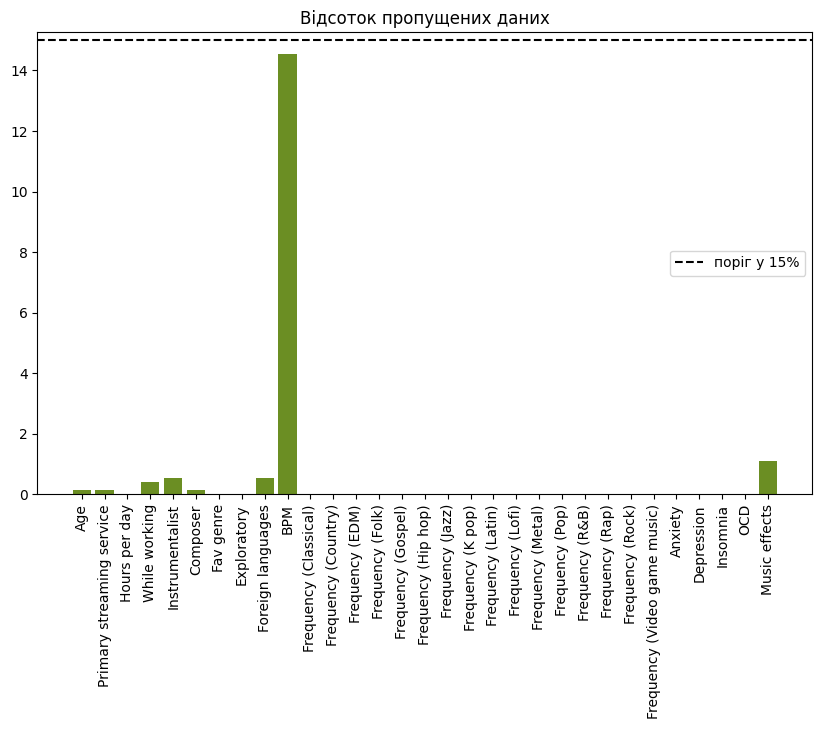

In [ ]:
plot_nan_percentage(df)

In [ ]:
fill_nan(df)

NaN для числових ознак успішно заповнені медіаною, для категоріальних - модою


## Видалення аномалій

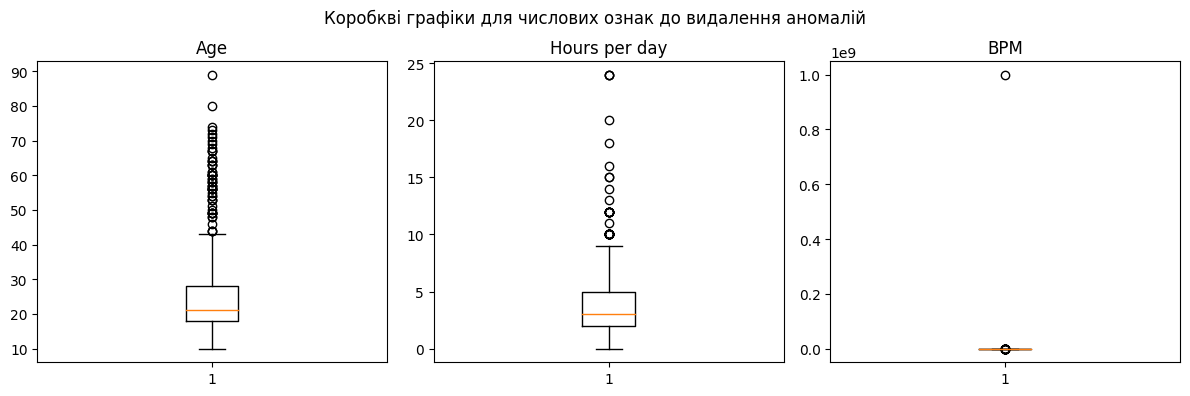

In [ ]:
anomaly_check(df)

In [ ]:
df["BPM"].replace(df["BPM"].max(), np.nan, inplace=True)
df["BPM"].fillna(df["BPM"].median(), inplace=True)

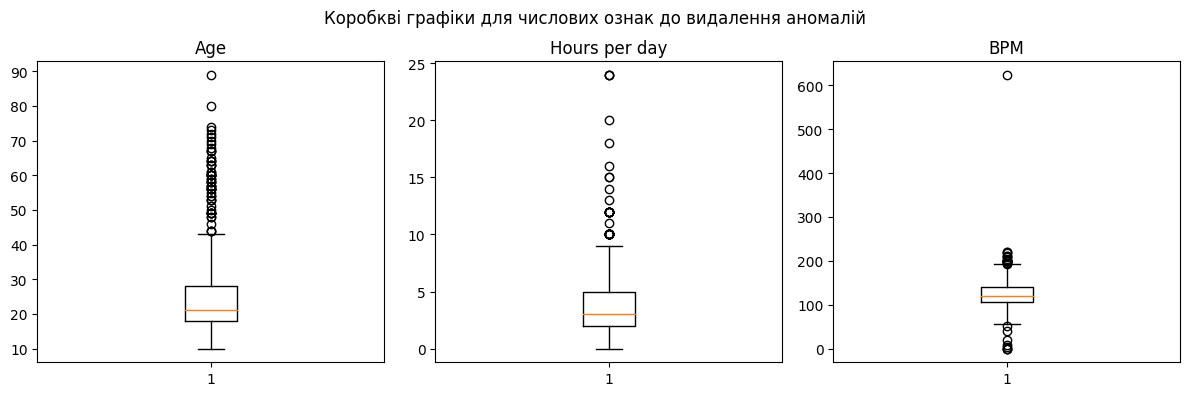

In [ ]:
anomaly_check(df)

## Кодування та масштабування


In [ ]:
X, y = get_X_y(df)

X_norm = scale(X, mode='minmax')
X_stand = scale(X, mode='standard')
X_enc_norm_old = encode(X_norm)
X_enc_stand_old = encode(X_stand)

## Дослідження розподілів

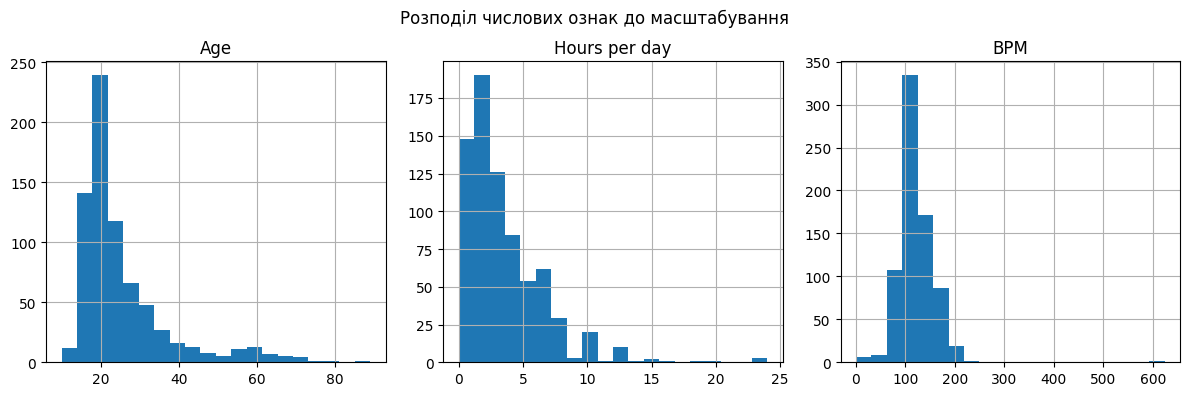

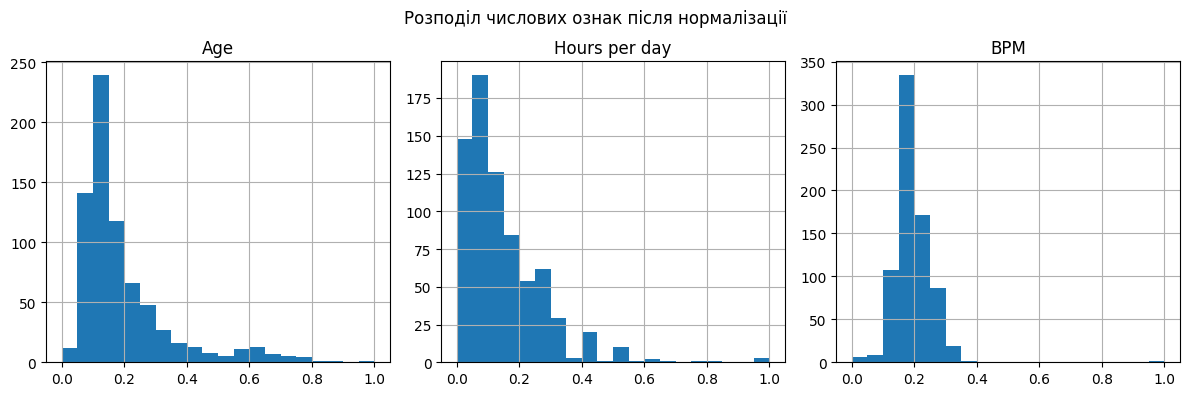

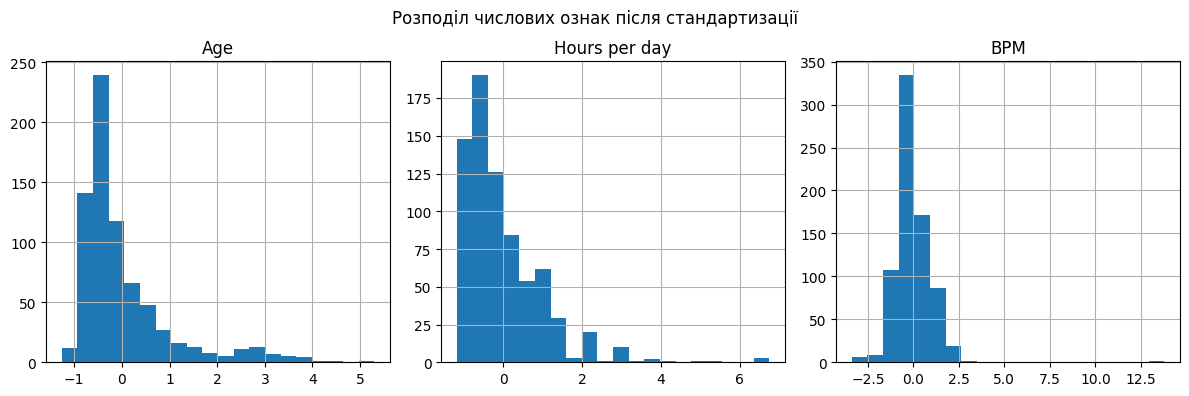

In [ ]:
plot_distribution(X)
plot_distribution(X_norm, 'minmax')
plot_distribution(X_stand, 'standard')

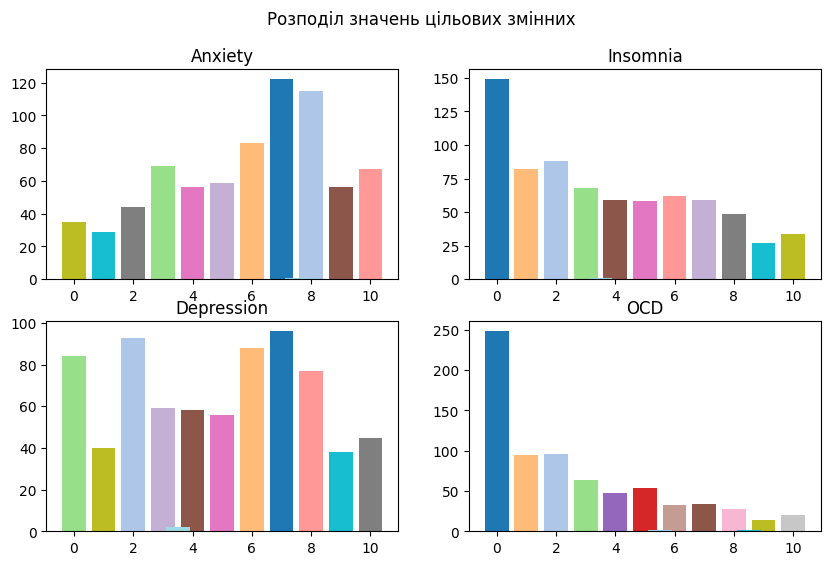

In [ ]:
plot_variables(y)

## Grid Search для вибору значущих ознак

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search(X_enc_stand_old, y, param_grid, 'rf')

Параметр          Найкраще значення
max_depth                None      
max_features             sqrt      
min_samples_leaf            4      
min_samples_split          10      
n_estimators              200      


## Вибір значущих ознак

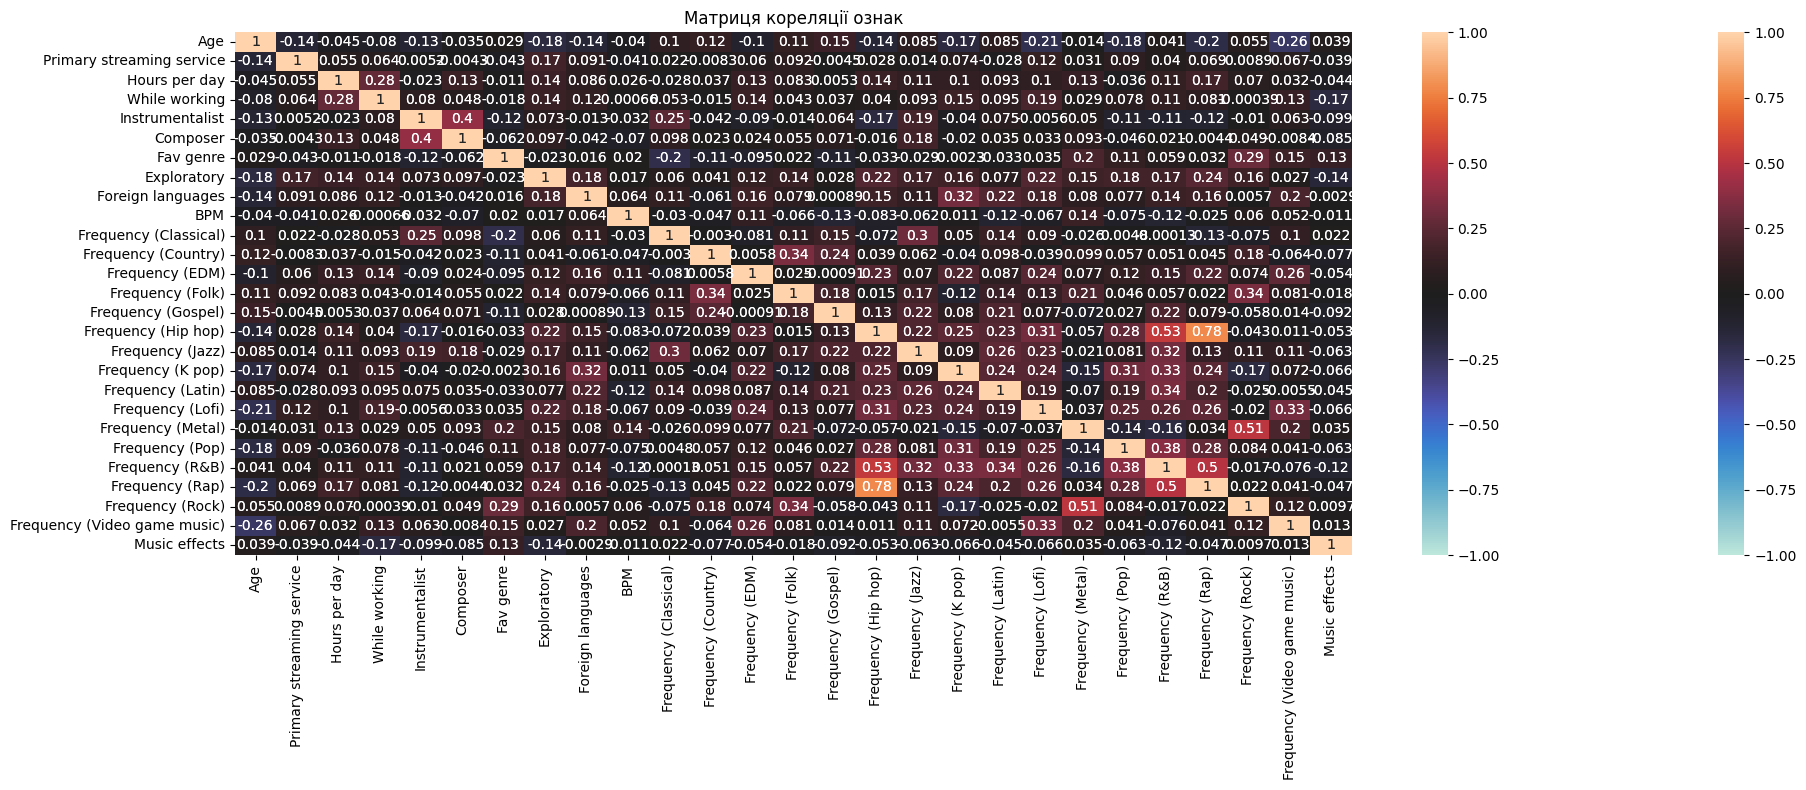

In [ ]:
correlation(X_enc_stand_old)

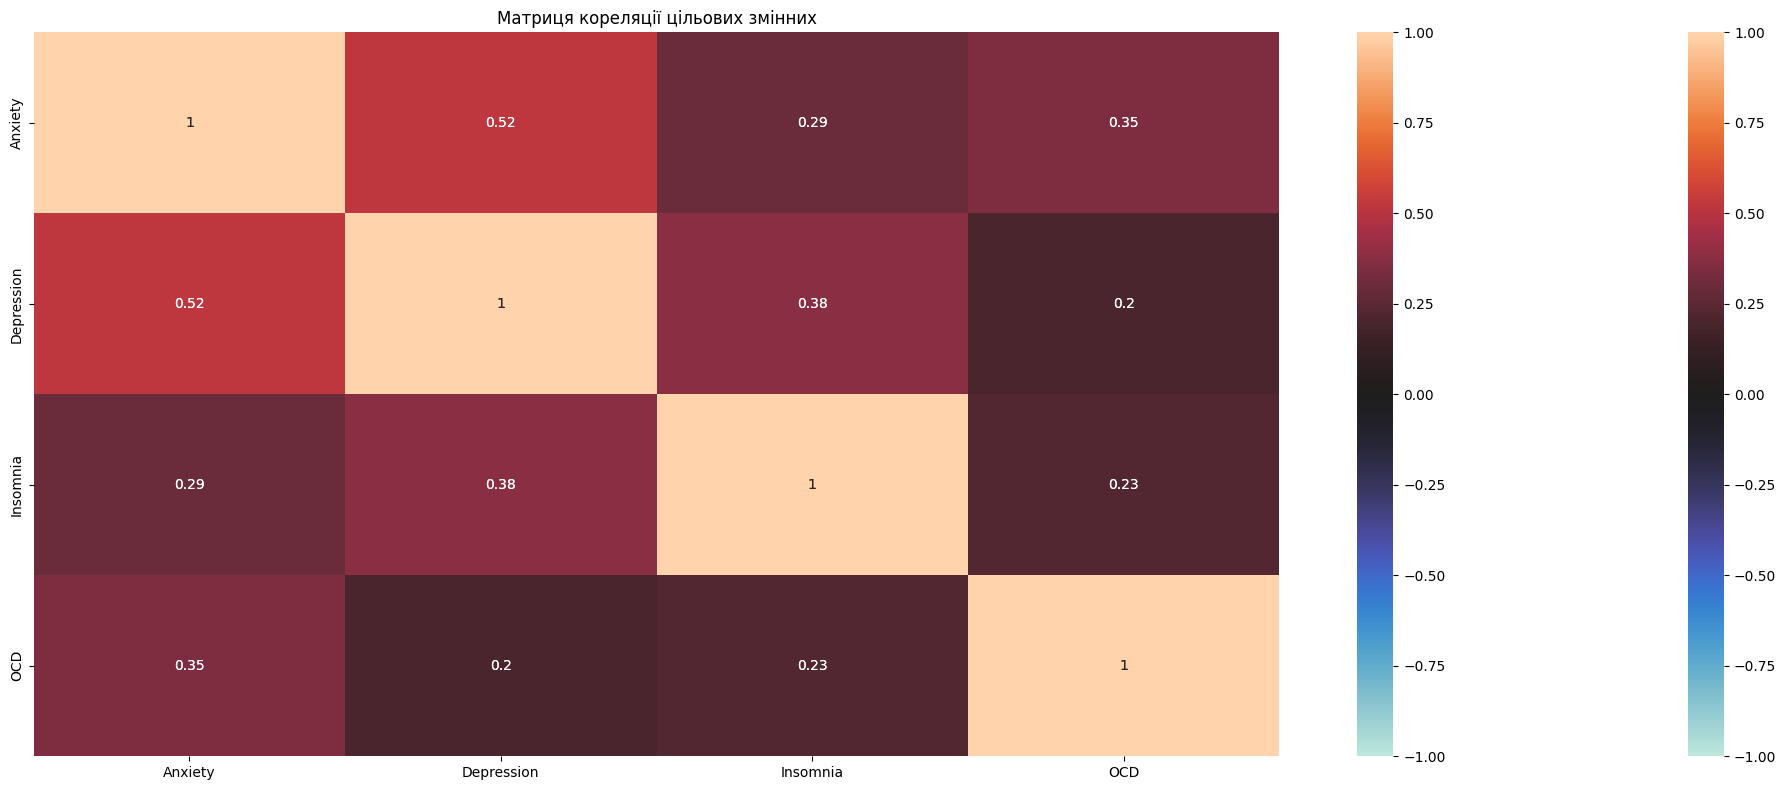

In [ ]:
correlation(y, mode='variables')

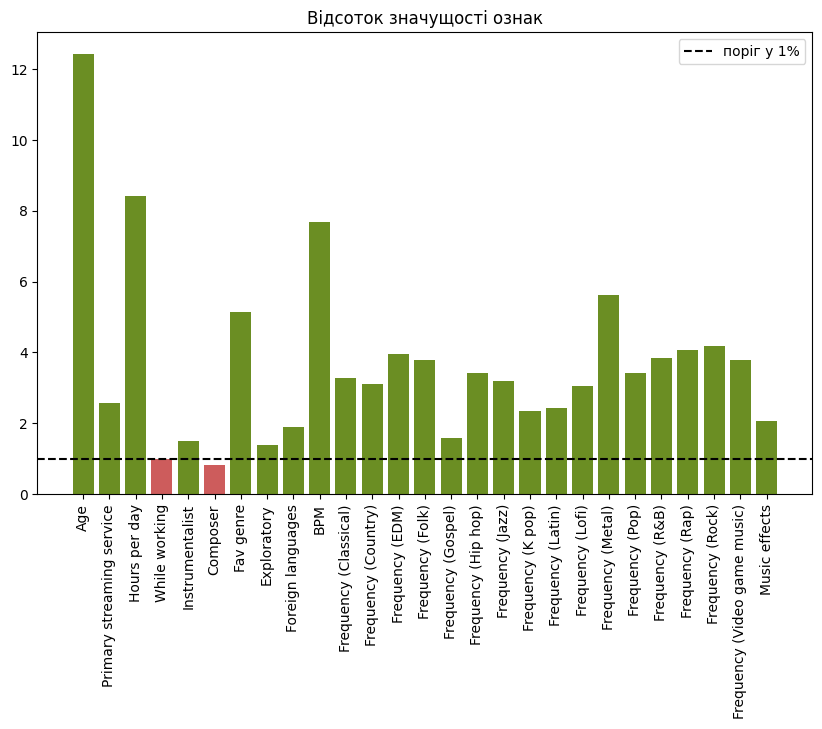

In [ ]:
X_enc_stand_per, X_enc_norm_per = select_features(X_enc_stand_old, X_enc_norm_old, y, mode='thresh')

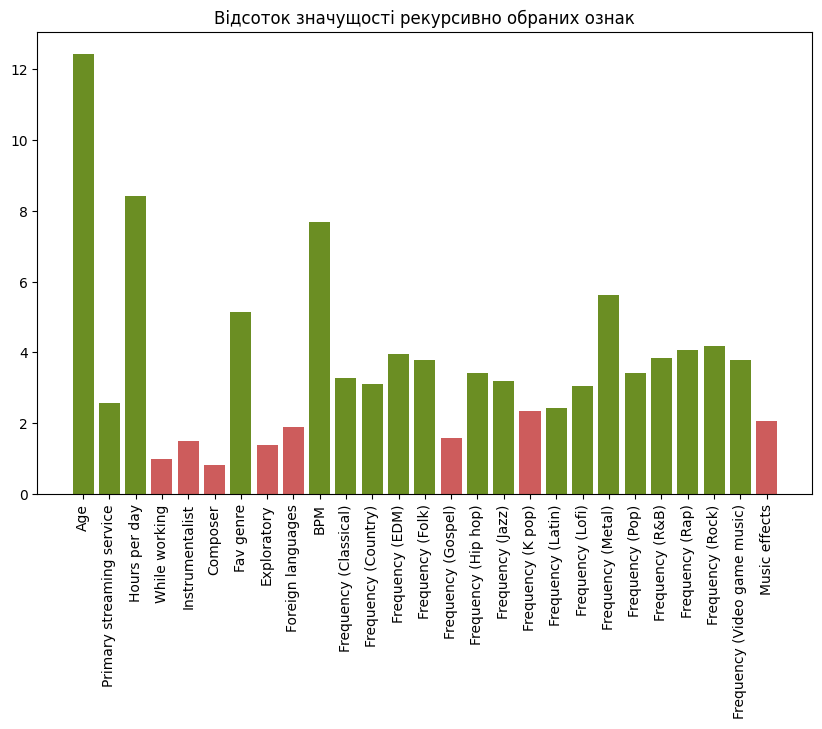

In [ ]:
X_enc_stand_rec, X_enc_norm_rec = select_features(X_enc_stand_old, X_enc_norm_old, y, mode='rec')

# Grid Search для моделей

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = make_splits(X_enc_stand_per, y, number=3)

y_div_train = y_division(y_train)
y_div_test = y_division(y_test)
y_div_val = y_division(y_val)

In [ ]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.3]
}

grid_search(X_val, y_div_val[0], param_grid, 'svr')

Параметр Найкраще значення
C                  1      
epsilon          0.3      
gamma           auto      
kernel           rbf      


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search(X_val, y_val, param_grid, 'et')

Параметр          Найкраще значення
max_depth                   5      
max_features             log2      
min_samples_leaf            4      
min_samples_split          10      
n_estimators              100      


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_samples': [0.6, 0.8, 1.0],
    'max_features': [0.6, 0.8, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
}

grid_search(X_val, y_val, param_grid, 'bg')

Параметр           Найкраще значення
bootstrap                 False     
bootstrap_features        False     
max_features                0.6     
max_samples                 0.8     
n_estimators                 50     


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

grid_search(X_val, y_val, param_grid, 'xgb')

Параметр         Найкраще значення
colsample_bytree         0.6      
gamma                    0.1      
learning_rate           0.01      
max_depth                  7      
n_estimators             300      
reg_alpha                0.5      
reg_lambda               0.1      
subsample                0.6      


In [ ]:
model = LGBMRegressor()

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

grid_search(X_val, y_div_val[0], param_grid, 'lgbm')

Параметр         Найкраще значення
colsample_bytree          0.6     
learning_rate           0.001     
max_depth                   3     
n_estimators              100     
reg_alpha                 0.1     
reg_lambda                0.5     
subsample                 0.6     


In [ ]:
model = CatBoostRegressor()

param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bylevel': [0.6, 0.8, 1.0],
    'reg_lambda': [0, 0.1, 0.5]
}

grid_search(X_val, y_div_val[0], param_grid, 'cat')

Параметр          Найкраще значення
colsample_bylevel         0.6      
depth                       5      
iterations                300      
learning_rate             0.1      
reg_lambda                0.5      
subsample                 0.8      


In [ ]:
with open('/content/drive/MyDrive/Diploma/Regression/best_model_xgb.pkl', 'rb') as f:
    xgb = pickle.load(f)
with open('/content/drive/MyDrive/Diploma/Regression/best_model_lgbm.pkl', 'rb') as f:
    lgbm = pickle.load(f)
with open('/content/drive/MyDrive/Diploma/Regression/best_model_cat.pkl', 'rb') as f:
    cat = pickle.load(f)

estimators = [
    ('xgb', xgb),
    ('lgbm', lgbm),
    ('cat', cat)
]

with open(f'/content/drive/MyDrive/Diploma/Regression/best_model_et.pkl', 'rb') as f:
    final_estimator = pickle.load(f)

st = StackingRegressor(estimators=estimators, final_estimator=final_estimator)
with open('/content/drive/MyDrive/Diploma/Regression/best_model_st.pkl', 'wb') as f:
    pickle.dump(st, f)

# Прогнози за найкращими моделями

## Пороговий вибір ознак

In [ ]:
X_train_stand_per, X_test_stand_per, y_train_stand_per, y_test_stand_per = make_splits(X_enc_stand_per, y)

y_div_train_stand_per = y_division(y_train_stand_per)
y_div_test_stand_per = y_division(y_test_stand_per)

In [ ]:
make_prediction(X_train_stand_per, X_test_stand_per, y_train_stand_per, y_test_stand_per, y_div_train_stand_per, y_div_test_stand_per)

       Модель        RMSE        MAE          R2         Час навчання
                    train  test train  test train  test              
                SVR 2.553 3.144 1.856 2.487 0.211 -0.173     0.04    
ExtraTreesRegressor 2.703 2.928 2.294 2.491 0.149  0.010     0.19    
   BaggingRegressor 2.739 2.926 2.324 2.490 0.127  0.012    10.76    
       XGBRegressor 1.408 2.967 1.160 2.479 0.769 -0.016    18.65    
      LGBMRegressor 2.862 2.920 2.403 2.454 0.013 -0.010     0.13    
  CatBoostRegressor 0.774 3.152 0.607 2.577 0.927 -0.176     0.36    
  StackingRegressor 2.731 2.928 2.280 2.462 0.092 -0.016     4.68    


## Рекурсивний вибір ознак

In [ ]:
X_train_stand_rec, X_test_stand_rec, y_train_stand_rec, y_test_stand_rec = make_splits(X_enc_stand_rec, y)

y_div_train_stand_rec = y_division(y_train_stand_rec)
y_div_test_stand_rec = y_division(y_test_stand_rec)

In [ ]:
make_prediction(X_train_stand_rec, X_test_stand_rec, y_train_stand_rec, y_test_stand_rec, y_div_train_stand_rec, y_div_test_stand_rec)

       Модель        RMSE        MAE          R2         Час навчання
                    train  test train  test train  test              
                SVR 2.530 3.149 1.832 2.489 0.225 -0.177     0.05    
ExtraTreesRegressor 2.703 2.916 2.290 2.477 0.149  0.018     0.19    
   BaggingRegressor 2.735 2.924 2.318 2.487 0.129  0.013     5.98    
       XGBRegressor 1.452 2.967 1.195 2.477 0.754 -0.017     1.20    
      LGBMRegressor 2.863 2.921 2.404 2.455 0.012 -0.011     0.02    
  CatBoostRegressor 0.831 3.127 0.651 2.550 0.916 -0.158     0.15    
  StackingRegressor 2.790 2.928 2.317 2.460 0.052 -0.015     4.21    


## Нормалізовані дані

In [ ]:
X_train_norm_rec, X_test_norm_rec, y_train_norm_rec, y_test_norm_rec = make_splits(X_enc_norm_rec, y)

y_div_train_norm_rec = y_division(y_train_norm_rec)
y_div_test_norm_rec = y_division(y_test_norm_rec)

In [ ]:
make_prediction(X_train_norm_rec, X_test_norm_rec, y_train_norm_rec, y_test_norm_rec, y_div_train_norm_rec, y_div_test_norm_rec)

       Модель        RMSE        MAE          R2         Час навчання
                    train  test train  test train  test              
                SVR 2.601 3.180 1.900 2.512 0.182 -0.200     0.05    
ExtraTreesRegressor 2.703 2.916 2.290 2.477 0.149  0.018     0.24    
   BaggingRegressor 2.735 2.924 2.318 2.487 0.129  0.013     7.36    
       XGBRegressor 1.455 2.970 1.197 2.482 0.753 -0.019     1.22    
      LGBMRegressor 2.863 2.921 2.404 2.455 0.012 -0.011     0.03    
  CatBoostRegressor 0.831 3.127 0.651 2.550 0.916 -0.158     0.15    
  StackingRegressor 2.789 2.925 2.315 2.457 0.050 -0.013     2.96    


# Покращення моделей




## Крос-валідація

In [ ]:
y_div = y_division(y)

scoring = {'R2': 'r2',
           'RMSE': make_scorer(mean_squared_error, squared=False),
           'MAE': make_scorer(mean_absolute_error)}

In [ ]:
make_cv_prediction(X_enc_stand_rec, y_div, scoring)

       Модель        RMSE        MAE          R2         Час навчання
                    train  test train  test train  test              
                SVR 2.489 2.991 1.899 2.454 0.278 -0.053     0.02    
ExtraTreesRegressor 2.666 2.897 2.266 2.463 0.174  0.013     0.16    
   BaggingRegressor 2.716 2.897 2.310 2.466 0.143  0.014     6.53    
       XGBRegressor 1.443 2.938 1.192 2.466 0.757 -0.016     0.62    
      LGBMRegressor 2.912 2.932 2.483 2.504 0.015 -0.010     0.02    
  CatBoostRegressor 0.857 3.085 0.667 2.556 0.914 -0.122     0.23    
  StackingRegressor 2.638 2.919 2.232 2.490 0.186 -0.001     3.71    


## Округлені прогнози

In [ ]:
make_prediction(X_train_stand_rec, X_test_stand_rec, y_train_stand_rec, y_test_stand_rec, y_div_train_stand_rec, y_div_test_stand_rec, rounded=True)

       Модель        RMSE        MAE          R2         Час навчання
                    train  test train  test train  test              
                SVR 2.539 3.146 1.863 2.481 0.219 -0.174     0.02    
ExtraTreesRegressor 2.709 2.925 2.295 2.482 0.145  0.012     0.08    
   BaggingRegressor 2.740 2.931 2.319 2.487 0.126  0.008     4.38    
       XGBRegressor 1.457 2.984 1.185 2.484 0.752 -0.028     0.96    
      LGBMRegressor 2.851 2.920 2.382 2.438 0.020 -0.010     0.03    
  CatBoostRegressor 0.848 3.127 0.644 2.550 0.913 -0.158     0.12    
  StackingRegressor 2.782 2.929 2.290 2.454 0.056 -0.016     3.15    


## Класифікація

### Збереження класифікаторів

In [ ]:
svc = SVC(kernel='rbf', C=1, gamma='auto', random_state=42)
with open('/content/drive/MyDrive/Diploma/Classification/best_model_svc.pkl', 'wb') as f:
  pickle.dump(svc, f)

In [ ]:
et = ExtraTreesClassifier(n_estimators=100, max_depth=5, min_samples_leaf=4, min_samples_split=10, max_features='log2', random_state=42)
with open('/content/drive/MyDrive/Diploma/Classification/best_model_et.pkl', 'wb') as f:
  pickle.dump(et, f)

In [ ]:
with open('/content/drive/MyDrive/Diploma/Classification/best_model_et.pkl', 'rb') as f:
  base_estimator = pickle.load(f)
bg = BaggingClassifier(estimator=base_estimator, n_estimators=50, max_samples=0.8, max_features=0.6, bootstrap=False, bootstrap_features=False, random_state=42)
with open('/content/drive/MyDrive/Diploma/Classification/best_model_bg.pkl', 'wb') as f:
  pickle.dump(bg, f)

In [ ]:
xgb = XGBClassifier(n_estimators=300, subsample=0.6, max_depth=7, learning_rate=0.01, colsample_bytree=0.6, gamma=0.1, reg_alpha=0.5, reg_lambda=0.1, random_state=42)
with open('/content/drive/MyDrive/Diploma/Classification/best_model_xgb.pkl', 'wb') as f:
    pickle.dump(xgb, f)

In [ ]:
lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.001, max_depth=3, subsample=0.6, colsample_bytree=0.6, reg_alpha=0.1, reg_lambda=0.5, random_state=42)
with open('/content/drive/MyDrive/Diploma/Classification/best_model_lgbm.pkl', 'wb') as f:
  pickle.dump(lgbm, f)

In [ ]:
cat = CatBoostClassifier(iterations=300, depth=5, subsample=0.8, colsample_bylevel=0.6, learning_rate=0.1, reg_lambda=0.5, bootstrap_type='MVS', random_seed=42, verbose=False)
with open('/content/drive/MyDrive/Diploma/Classification/best_model_cat.pkl', 'wb') as f:
  pickle.dump(cat, f)

In [ ]:
with open(f'/content/drive/MyDrive/Diploma/Classification/best_model_xgb.pkl', 'rb') as f:
    xgb = pickle.load(f)
with open(f'/content/drive/MyDrive/Diploma/Classification/best_model_lgbm.pkl', 'rb') as f:
    lgbm = pickle.load(f)
with open(f'/content/drive/MyDrive/Diploma/Classification/best_model_cat.pkl', 'rb') as f:
    cat = pickle.load(f)

estimators = [
    ('xgb', xgb),
    ('lgbm', lgbm),
    ('cat', cat)
]

with open(f'/content/drive/MyDrive/Diploma/Classification/best_model_et.pkl', 'rb') as f:
    final_estimator = pickle.load(f)

st = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
with open('/content/drive/MyDrive/Diploma/Classification/best_model_st.pkl', 'wb') as f:
    pickle.dump(st, f)

### Результат класифікації

In [ ]:
X_enc_stand_red, y_red = drop_small_classes(X_enc_stand_rec, y)
y_enc = encode(y_red, mode='all')
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_enc_stand_red, y_enc)
y_div_train_clf = y_division(y_train_clf)
y_div_test_clf = y_division(y_test_clf)

In [ ]:
make_prediction(X_train_clf, X_test_clf, y_train_clf, y_test_clf, y_div_train_clf, y_div_test_clf, clf=True)

       Модель        Accuracy       Час навчання
                      train    test             
                 SVC  0.456   0.254     0.04    
ExtraTreesClassifier  0.351   0.245     0.13    
   BaggingClassifier  0.325   0.240     8.03    
       XGBClassifier  0.925   0.217     2.20    
      LGBMClassifier  0.266   0.246     0.17    
  CatBoostClassifier  1.000   0.198     0.61    
  StackingClassifier  0.240   0.232    21.13    


## Альтернативні задачі

### Модифікована класифікація

In [ ]:
y_mod = make_ranges(y)
y_mod_enc = encode(y_mod, mode='all')
X_train_clf_mod, X_test_clf_mod, y_train_clf_mod, y_test_clf_mod = make_splits(X_enc_stand_rec, y_mod_enc)
y_div_train_clf_mod = y_division(y_train_clf_mod)
y_div_test_clf_mod = y_division(y_test_clf_mod)

In [ ]:
make_prediction(X_train_clf_mod, X_test_clf_mod, y_train_clf_mod, y_test_clf_mod, y_div_train_clf_mod, y_div_test_clf_mod, clf=True)

       Модель        Accuracy       Час навчання
                      train    test             
                 SVC  0.708   0.468     0.05    
ExtraTreesClassifier  0.605   0.498     0.21    
   BaggingClassifier  0.586   0.493     8.01    
       XGBClassifier  0.940   0.476     0.86    
      LGBMClassifier  0.535   0.507     0.06    
  CatBoostClassifier  0.999   0.427     0.29    
  StackingClassifier  0.604   0.490     9.66    


### Пошук асоціативних правил

In [ ]:
find_association(X, y, 'anx')

                                                                                    Чинники тривожності
         (While working_Yes, Exploratory_Yes, Primary streaming service_Spotify, Music effects_Improve)
(While working_Yes, Primary streaming service_Spotify, Frequency (Gospel)_Never, Music effects_Improve)
                  (While working_Yes, Exploratory_Yes, Frequency (Gospel)_Never, Music effects_Improve)


In [ ]:
find_association(X, y, 'dep')

                                                                              Чинники депресії
(While working_Yes, Exploratory_Yes, Primary streaming service_Spotify, Music effects_Improve)
                      (While working_Yes, Exploratory_Yes, Foreign languages_Yes, Composer_No)
            (While working_Yes, Exploratory_Yes, Foreign languages_Yes, Music effects_Improve)


In [ ]:
find_association(X, y, 'ins')

                                                                     Чинники безсоння
(Instrumentalist_No, Exploratory_Yes, Primary streaming service_Spotify, Composer_No)
                (While working_Yes, Exploratory_Yes, Composer_No, Instrumentalist_No)
            (Instrumentalist_No, Exploratory_Yes, Composer_No, Music effects_Improve)


In [ ]:
find_association(X, y, 'ocd')

                                                                                   Чинники ОКР
(While working_Yes, Exploratory_Yes, Primary streaming service_Spotify, Music effects_Improve)
                         (While working_Yes, Exploratory_Yes, Composer_No, Instrumentalist_No)
                   (While working_Yes, Composer_No, Music effects_Improve, Instrumentalist_No)


# Результат на власному опитуванні

In [19]:
custom_research('drive/My Drive/Diploma/custom_survey.csv')

ID респондента Тривожність            Депресія             Безсоння               ОКР             
               прогнозовані вказані прогнозовані вказані прогнозовані вказані прогнозовані вказані
      1            5,5         5        4,5         3          3         2          2         2   
      2            5,5         6          4         2          3         1        2,5         1   
      3            5,5         4        4,5         3        3,5         4        2,5         0   
      4              5         3        3,5         4          3         2          0         1   
      5            5,5         7        4,5         5          3         0        2,5         5   
